Import thư viện

In [8]:
import json
import time
import pandas as pd  # Thư viện để tạo và hiển thị bảng đẹp mắt
from openai import OpenAI
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Import TẤT CẢ các mẫu prompt từ file prompt.py
from prompt import *

Chạy API key và Lấy sample

In [ ]:
# !!! QUAN TRỌNG: Hãy điền API Key của bạn vào đây
api_key = "..."  # Thay thế bằng API Key của bạn

# 1. Khởi tạo Client với API Key
client = OpenAI(api_key=api_key)

# 2. Định nghĩa các "thí sinh" (model) và tất cả các "bài thi" (prompt)
MODELS_TO_COMPARE = ["gpt-3.5-turbo", "gpt-4o-mini"]
PROMPTS_TO_TEST = {
    # Key là tên sẽ hiển thị trong bảng, Value là biến prompt từ file prompt.py
    "English Prompt (1-shot)": ENGLISH_ONE,
    "Persian Prompt (1-shot)": PERSIAN_ONE,
    "English Prompt (3-shot)": ENGLISH_THREE,
    "Persian Prompt (3-shot)": PERSIAN_THREE,
    "English Prompt (Zero-shot)": ENGLISH_ZERO,
    "Persian Prompt (Zero-shot)": PERSIAN_ZERO
}

# 3. Tải toàn bộ dữ liệu từ file data.jsonl
try:
    all_data = []
    with open('data.jsonl', 'r', encoding='utf-8') as reader:
        for line in reader:
            all_data.append(json.loads(line))
    print(f" Đã tải thành công {len(all_data)} mẫu dữ liệu từ 'data.jsonl'.")
except FileNotFoundError:
    print(" Lỗi: Không tìm thấy file 'data.jsonl'. Hãy chắc chắn file này nằm cùng thư mục.")

 Đã tải thành công 200 mẫu dữ liệu từ 'data.jsonl'.


Hàm nhận prompt và TÊN MODEL, trả về câu trả lời.

In [ ]:
def get_answer_from_model(prompt, model_name):
    """
    Hàm này nhận một prompt và tên model, sau đó trả về câu trả lời.
    """
    try:
        response = client.chat.completions.create(
          model=model_name,
          messages=[
                {"role": "system", "content": "You are a helpful assistant for natural language inference."},
                {"role": "user", "content": prompt}
            ],
          temperature=0,
          max_tokens=15
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        # In ra lỗi nếu có vấn đề với API nhưng không dừng chương trình
        print(f"\nLỗi khi gọi model {model_name}: {e}")
        return "ERROR"

In [4]:
final_results = {}

In [48]:
# Dictionary để lưu kết quả cuối cùng
final_results = {}

# Lấy danh sách nhãn đúng một lần duy nhất
true_labels = [sample['target'] for sample in all_data]

# Bắt đầu vòng lặp lớn
for model_name in MODELS_TO_COMPARE:
    print(f"============== BẮT ĐẦU MODEL: {model_name} ==============")
    final_results[model_name] = {}
    
    # Vòng lặp bên trong: chạy qua từng loại prompt
    for prompt_name, prompt_template in PROMPTS_TO_TEST.items():
        print(f"--- 🚀 Đang chạy kịch bản: {prompt_name} ---")
        
        model_predictions = []
        
        # Chạy qua toàn bộ dữ liệu cho kịch bản hiện tại
        for sample in tqdm(all_data, desc=f"Querying {prompt_name}"):
            # Lưu ý: file prompt.py của bạn dùng {premise} và {hypothesis}
            prompt = prompt_template.format(premise=sample['Fa_premise'], hypothesis=sample['Fa_hypothesis'])
            answer = get_answer_from_model(prompt, model_name)
            model_predictions.append(answer)
            time.sleep(1) # Chờ 1 giây để tránh bị giới hạn API

        # Chuẩn hóa kết quả và tính accuracy
        normalized_predictions = []
        for pred in model_predictions:
            # Xóa khoảng trắng, dấu nháy đơn và chuyển về chữ thường
            clean_pred = str(pred).strip().lower().replace("'", "")
            if clean_pred.startswith('e'):
                normalized_predictions.append('e')
            elif clean_pred.startswith('c'):
                normalized_predictions.append('c')
            elif clean_pred.startswith('n'):
                normalized_predictions.append('n')
            else:
                normalized_predictions.append('unknown') # Dành cho các câu trả lời không hợp lệ
        
        accuracy = accuracy_score(true_labels, normalized_predictions)
        # Lưu kết quả accuracy (dưới dạng %) vào dictionary
        final_results[model_name][prompt_name] = accuracy * 100
        print(f"--- 🎉 Hoàn thành. Accuracy: {accuracy*100:.2f}% ---\n")

print("✨ Đã hoàn thành tất cả các thử nghiệm.")

============== BẮT ĐẦU MODEL: gpt-3.5-turbo ==============
--- 🚀 Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 200/200 [05:22<00:00,  1.61s/it]


--- 🎉 Hoàn thành. Accuracy: 32.50% ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 200/200 [05:24<00:00,  1.62s/it]


--- 🎉 Hoàn thành. Accuracy: 34.50% ---

--- 🚀 Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 200/200 [05:34<00:00,  1.67s/it]


--- 🎉 Hoàn thành. Accuracy: 12.00% ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 200/200 [05:31<00:00,  1.66s/it]


--- 🎉 Hoàn thành. Accuracy: 43.50% ---

--- 🚀 Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [05:31<00:00,  1.66s/it]


--- 🎉 Hoàn thành. Accuracy: 24.00% ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [05:38<00:00,  1.69s/it]


--- 🎉 Hoàn thành. Accuracy: 24.00% ---

============== BẮT ĐẦU MODEL: gpt-4o-mini ==============
--- 🚀 Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 200/200 [05:32<00:00,  1.66s/it]


--- 🎉 Hoàn thành. Accuracy: 60.50% ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 200/200 [05:32<00:00,  1.66s/it]


--- 🎉 Hoàn thành. Accuracy: 50.50% ---

--- 🚀 Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 200/200 [05:26<00:00,  1.63s/it]


--- 🎉 Hoàn thành. Accuracy: 61.50% ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 200/200 [05:31<00:00,  1.66s/it]


--- 🎉 Hoàn thành. Accuracy: 51.00% ---

--- 🚀 Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [05:15<00:00,  1.58s/it]


--- 🎉 Hoàn thành. Accuracy: 59.50% ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [05:43<00:00,  1.72s/it]

--- 🎉 Hoàn thành. Accuracy: 44.50% ---

✨ Đã hoàn thành tất cả các thử nghiệm.


In [49]:
print(prompt)

    به شما یک پیش فرض و یک فرضیه در مورد آن پیش فرض ارائه می شود. 
     شما باید با انتخاب یکی از پاسخ های زیر تصمیم بگیرید که آیا فرضیه مستلزم پیش فرض است:
     'e': فرضیه به طور منطقی از اطلاعات موجود در پیش فرض ناشی می شود. 
     'c': فرضیه از نظر منطقی از اطلاعات موجود در پیش فرض نادرست است. 
     'n': تشخیص درست یا نادرست بودن فرضیه بدون اطلاعات بیشتر ممکن نیست.
     قسمت اطلاعات را به طور کامل بخوانید و از بین سه برچسب پاسخ، پاسخ صحیح را انتخاب کنید. 
     پیش فرض را به طور کامل بخوانید تا مطمئن شوید که پیش فرض را شامل می شود.
    
    پیش فرض:
    ''' بخشی از شهر ژوهانسبورگ است و در نزدیکی حومه طبقه بالای سندتون قرار دارد.'''
    فرضیه:
    ''' بخشی از شهر دوربان است و در نزدیکی حومه طبقه بالا سندتون قرار دارد.'''
    پاسخ:



In [50]:
# Chuyển dictionary kết quả thành một DataFrame của pandas
results_df = pd.DataFrame(final_results)

# Định dạng lại các số để chỉ hiển thị 2 chữ số thập phân và thêm ký tự '%'
results_df = results_df.applymap(lambda x: f"{x:.2f}%" if isinstance(x, float) else x)

# Đặt lại tên cho các cột và hàng của bảng
results_df.columns.name = "Model"
results_df.index.name = "Prompt / Kịch bản"

print("\n\n📊=============== BẢNG SO SÁNH HIỆU NĂNG TOÀN DIỆN ===============📊")
# In ra bảng dưới dạng Markdown, có thể copy/paste dễ dàng vào báo cáo
print(results_df.to_markdown())



📊=============== BẢNG SO SÁNH HIỆU NĂNG TOÀN DIỆN ===============📊
| Prompt / Kịch bản          | gpt-3.5-turbo   | gpt-4o-mini   |
|:---------------------------|:----------------|:--------------|
| English Prompt (1-shot)    | 32.50%          | 60.50%        |
| Persian Prompt (1-shot)    | 34.50%          | 50.50%        |
| English Prompt (3-shot)    | 12.00%          | 61.50%        |
| Persian Prompt (3-shot)    | 43.50%          | 51.00%        |
| English Prompt (Zero-shot) | 24.00%          | 59.50%        |
| Persian Prompt (Zero-shot) | 24.00%          | 44.50%        |


C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_18140\3013447151.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df = results_df.applymap(lambda x: f"{x:.2f}%" if isinstance(x, float) else x)




📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT NLI ===============📈


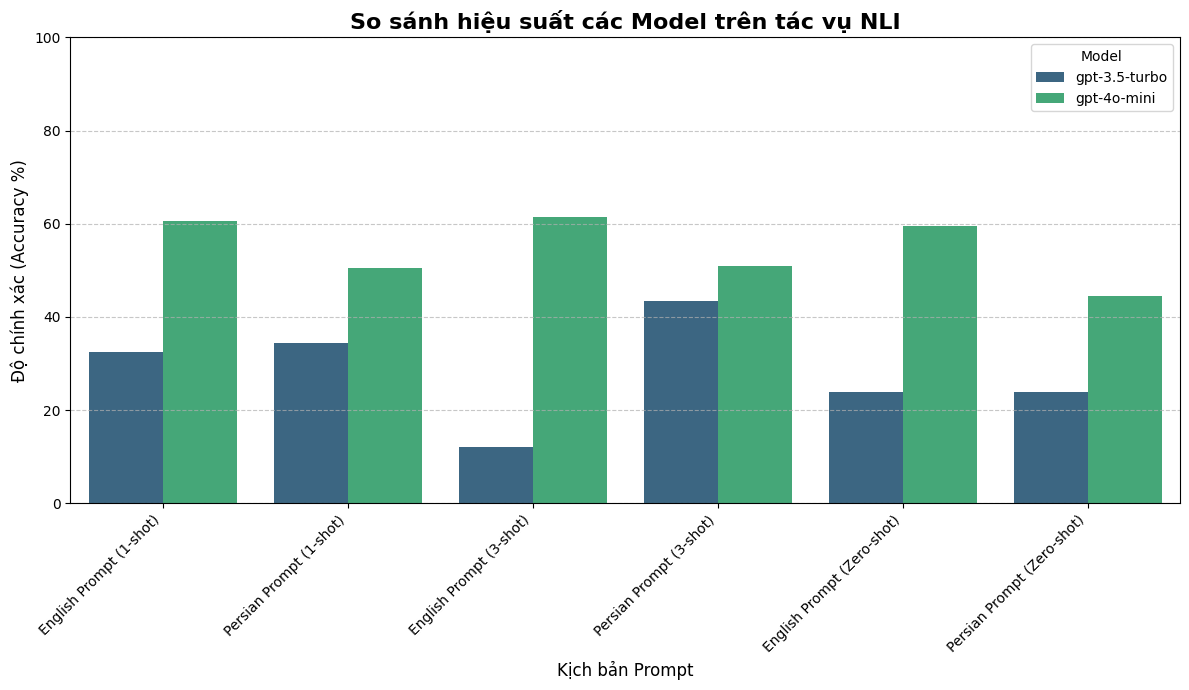

In [10]:
print("\n\n📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT NLI ===============📈")


# Dữ liệu hiệu suất NLI trực tiếp từ bảng bạn cung cấp
nli_data = {
    'Prompt / Kịch bản': [
        'English Prompt (1-shot)', 'Persian Prompt (1-shot)',
        'English Prompt (3-shot)', 'Persian Prompt (3-shot)',
        'English Prompt (Zero-shot)', 'Persian Prompt (Zero-shot)'
    ],
    'gpt-3.5-turbo': [32.50, 34.50, 12.00, 43.50, 24.00, 24.00],
    'gpt-4o-mini': [60.50, 50.50, 61.50, 51.00, 59.50, 44.50]
}


nli_df_plot = pd.DataFrame(nli_data)


# Chuyển đổi DataFrame từ dạng rộng sang dạng dài để vẽ biểu đồ
nli_df_melted = nli_df_plot.melt(
    id_vars='Prompt / Kịch bản',
    value_vars=['gpt-3.5-turbo', 'gpt-4o-mini'],
    var_name='Model',
    value_name='Accuracy'
)


# Vẽ biểu đồ cột
plt.figure(figsize=(12, 7))
sns.barplot(data=nli_df_melted, x='Prompt / Kịch bản', y='Accuracy', hue='Model', palette='viridis')


# Tùy chỉnh biểu đồ
plt.title('So sánh hiệu suất các Model trên tác vụ NLI', fontsize=16, weight='bold')
plt.ylabel('Độ chính xác (Accuracy %)', fontsize=12)
plt.xlabel('Kịch bản Prompt', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.legend(title='Model', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


# Hiển thị biểu đồ
plt.show()

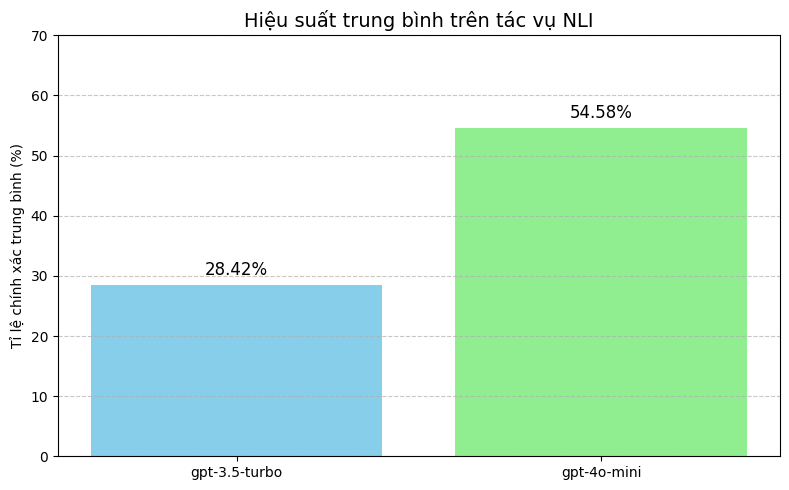

In [1]:
import matplotlib.pyplot as plt

# Hiệu suất từng prompt của tác vụ NLI
gpt_35_turbo_nli = [32.5, 34.5, 12.0, 43.5, 24.0, 24.0]
gpt_4o_mini_nli = [60.5, 50.5, 61.5, 51.0, 59.5, 44.5]

# Tính trung bình
avg_35 = sum(gpt_35_turbo_nli) / len(gpt_35_turbo_nli)
avg_4o = sum(gpt_4o_mini_nli) / len(gpt_4o_mini_nli)

# Vẽ biểu đồ
models = ['gpt-3.5-turbo', 'gpt-4o-mini']
avg_scores = [avg_35, avg_4o]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, avg_scores, color=['skyblue', 'lightgreen'])

# Gắn nhãn trên cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=12)

# Tùy chỉnh biểu đồ
plt.title('Hiệu suất trung bình trên tác vụ NLI', fontsize=14)
plt.ylabel('Tỉ lệ chính xác trung bình (%)')
plt.ylim(0, 70)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
